# Neural Chef Assistant

The task is to train a deep neural model for recipe generation.

## Imporitng the necessary libraries

In [1]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import mmap

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print("Using GPU?\n", torch.cuda.is_available())              # checking if GPU is available

Using GPU?
 True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementation of Baseline 1
In this we will implement a baseline encoder-decoder LSTM without any attention.

## Loading Data Files
The data contains a lot of files with ingedients and receipe to train. We'll represent each word as one hot encoded vector in our baseline model and then implement modifications in the more complex model.

In [16]:
# UNK tokens
SOS_token = 0
EOS_token = 1
UNK_token = 2  # Token for unknown words

class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS", UNK_token: "<UNK>"}
        self.n_words = 3  # Count SOS, EOS, and UNK

    def addSentence(self, sentence):
        for word in re.findall(r'\b\w+\b|\d+', sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

In [5]:
import os

def load_data_from_folders(folder_path):
    data = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.txt') or file.endswith('.TXT'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                    data.append(text)
            else:
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    if os.stat(file_path).st_size == 0:
                        continue
                    # Create a memory-mapped view of the file
                    mmapped_file = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)

                    # Read data from the memory-mapped file
                    text = mmapped_file.read()
                    text = text.decode('utf-8')   
                    data.append(text) 
    return data


In [6]:
def readData(datapath):
    # Read the file and split into lines
    file_path = "/content/drive/MyDrive/Cooking_Dataset"
    data = load_data_from_folders(file_path + '/' + datapath)
    ingredient = []
    recipe = []
    for text in data:
      ingredient_pattern = r'ingredients: (.*?)\n'
      recipe_pattern = r'ingredients: .*?\n(.*?)END RECIPE'
      ingredient.append(re.findall(ingredient_pattern, text))
      recipe.append(re.findall(recipe_pattern, text,re.DOTALL))
    
    ingredients = []
    [ingredients.extend(sublist) for sublist in ingredient] 
    recipes =[]
    [recipes.extend(sublist) for sublist in recipe]
    
    # normalizing the text in both ingredients and recipes list
    normalized_ingredients = [normalizeString(ingr) for ingr in ingredients]
    normalized_recipes = [normalizeString(rec) for rec in recipes]

    # creating pairs of (ingredient,recipe)
    pairs = list(zip(normalized_ingredients, normalized_recipes))
    
    return pairs


In [48]:
import statistics
# to get statistics about the data
def stats(datapath):
    pairs = readData(datapath)
    num_pairs = len(pairs)
    ingredient_lengths = [len(pair[0]) for pair in pairs]
    recipe_lengths = [len(pair[1]) for pair in pairs]
    
    min_ingredient_length = min(ingredient_lengths)
    max_ingredient_length = max(ingredient_lengths)
    avg_ingredient_length = sum(ingredient_lengths) / num_pairs
    median_ingredient_length = statistics.median(ingredient_lengths)
    std_ingredient_length = statistics.stdev(ingredient_lengths)
    
    min_recipe_length = min(recipe_lengths)
    max_recipe_length = max(recipe_lengths)
    avg_recipe_length = sum(recipe_lengths) / num_pairs
    median_recipe_length = statistics.median(recipe_lengths)
    std_recipe_length = statistics.stdev(recipe_lengths)

    input_ingr = Lang()
    output_rec = Lang()
    for pair in pairs:
        input_ingr.addSentence(pair[0])
        output_rec.addSentence(pair[1])
    
    statistics_ingredient = {
        "Number of Samples": num_pairs,
        "Vocab length": input_ingr.n_words,
        "Min length": min_ingredient_length,
        "Max length": max_ingredient_length,
        "Avg length": round(avg_ingredient_length,2),
        "Median length": round(median_ingredient_length,2),
        "Std Dev length": round(std_ingredient_length, 2)
    }

    statistics_recipe = {
        "Number of Samples": num_pairs,
        "Vocab length": output_rec.n_words,
        "Min length": min_recipe_length,
        "Max length": max_recipe_length,
        "Avg length": round(avg_recipe_length,2),
        "Median length": round(median_recipe_length,2),
        "Std Dev length": round(std_recipe_length, 2)
    }
    
    return statistics_ingredient, statistics_recipe


In [49]:
train_stats = stats('train')
dev_stats = stats('dev')
test_stats = stats('test')

In [50]:
import pandas as pd

index = pd.MultiIndex.from_tuples(
    [('Train', 'Ingredient'), ('Train', 'Recipe'),('Dev', 'Ingredient'), ('Dev', 'Recipe'), ('Test', 'Ingredient'),
     ('Test', 'Recipe')],
    names=['Data', 'Type'])

data = [train_stats[0], train_stats[1], dev_stats[0], dev_stats[1],test_stats[0],  test_stats[1]]

df = pd.DataFrame(data, index=index)

df

Number of Samples  Vocab length  Min length  Max length  \
Data  Type                                                                  
Train Ingredient             143907         19879           1        1945   
      Recipe                 143907         41540           0        4352   
Dev   Ingredient               1000          2422           6         772   
      Recipe                   1000          4553           9        2998   
Test  Ingredient               1000          2271           4         943   
      Recipe                   1000          4355          13        3965   

                  Avg length  Median length  Std Dev length  
Data  Type                                                   
Train Ingredient      205.41          189.0          107.44  
      Recipe          513.51          431.0          362.15  
Dev   Ingredient      200.30          184.0          111.96  
      Recipe          497.61          428.0          353.48  
Test  Ingredient      196.99          182.5          103.63  
      Recipe          507.21          419.0          374.69

In [7]:
MAX_LENGTH = 150
# for filtering out ingredient recipe with more than 150 words
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [19]:
import random
def prepareData(datapath, percentage=100):
    pairs = readData(datapath)
    print("Read %s ingredient-recipe pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s ingredient-recipe pairs" % len(pairs))

    if percentage < 100:
        num_pairs = int(len(pairs) * percentage / 100)
        pairs = random.sample(pairs, num_pairs)
        print("Using %s%% of pairs: %s ingredient-recipe pairs" % (percentage, len(pairs)))

    print("Counting words...")
    input_ingredient = Lang()
    output_recipe = Lang()
    for pair in pairs:
        input_ingredient.addSentence(pair[0])
        output_recipe.addSentence(pair[1])
    print("Counted words:")
    print("Ingredients:", input_ingredient.n_words)
    print("Recipes:", output_recipe.n_words)
    return input_ingredient, output_recipe, pairs

In [20]:
input_ingredient, output_recipe, pairs = prepareData('train',50)

Read 143907 ingredient-recipe pairs
Trimmed to 117294 ingredient-recipe pairs
Using 50% of pairs: 58647 ingredient-recipe pairs
Counting words...
Counted words:
Ingredients: 13280
Recipes: 24454


In [21]:
dev_input_ingredient, dev_output_recipe, dev_pairs = prepareData('dev',10)

Read 1000 ingredient-recipe pairs
Trimmed to 826 ingredient-recipe pairs
Using 10% of pairs: 82 ingredient-recipe pairs
Counting words...
Counted words:
Ingredients: 639
Recipes: 1173


In [22]:
test_input_ingredient, test_output_recipe, test_pairs = prepareData('test')

Read 1000 ingredient-recipe pairs
Trimmed to 830 ingredient-recipe pairs
Counting words...
Counted words:
Ingredients: 2042
Recipes: 3346


## Encoder LSTM

In [8]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),  # Initial hidden state 'h'
                torch.zeros(1, 1, self.hidden_size, device=device)) 

## Decoder LSTM

In [17]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size,dropout=0.1):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden_cell):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output = self.dropout(output)
        output, hidden_cell = self.lstm(output, hidden_cell)
        output = self.softmax(self.out(output[0]))
        return output, hidden_cell

    def initHiddenCell(self):
        return (
            torch.zeros(1, 1, self.hidden_size, device=device),
            torch.zeros(1, 1, self.hidden_size, device=device)
        )

## Preparing Training Data
To train, for each pair we will need an input tensor (indexes of the words in the input ingredients) and target tensor (indexes of the words in the target reciepe). While creating these vectors we will append the EOS token to both sequences.

In [23]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in re.findall(r'\b\w+\b|\d+', sentence)]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_lang = input_ingredient, output_lang = output_recipe):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Functions for training and evaluation

In [24]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [25]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, dev_pairs=dev_pairs):
    start = time.time()
    plot_losses = []
    dev_losses = []
    dev_bleu_scores = []
    plot_bleu_scores = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    random.shuffle(dev_pairs)
    dev_pairs = dev_pairs[:50]
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            # Evaluate on the validation set and print results
            dev_loss = 0
            for i in range(len(dev_pairs)):
                input_tensor = tensorFromSentence(input_ingredient, dev_pairs[i][0])
                target_tensor = tensorFromSentence(output_recipe, dev_pairs[i][1])
                dev_loss += eval_dev(encoder, decoder,input_tensor, target_tensor, 
                                  criterion)
            dev_loss_avg = dev_loss / len(dev_pairs)
            dev_bleu_score = calculate_bleu(dev_pairs, encoder, decoder, input_ingredient, output_recipe)
            dev_bleu_scores.append(dev_bleu_score)
            print('%s (%d %d%%) Train Loss: %.4f | Dev Loss: %.4f | Dev BLEU: %.4f' % (timeSince(start, iter / n_iters),
                                                                            iter, iter / n_iters * 100,
                                                                            print_loss_avg, dev_loss_avg,
                                                                            dev_bleu_score))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            # Calculate the BLEU score and dev loss every plot_every iterations
            dev_loss = 0
            random.shuffle(dev_pairs)
            dev_pairs_plot = dev_pairs[:round(len(dev_pairs)*0.5)]
            for i in range(len(dev_pairs_plot)):
                input_tensor = tensorFromSentence(input_ingredient, dev_pairs_plot[i][0])
                target_tensor = tensorFromSentence(output_recipe, dev_pairs_plot[i][1])
                dev_loss += eval_dev(encoder, decoder,input_tensor, target_tensor, 
                                  criterion)
            dev_loss_avg = dev_loss / len(dev_pairs_plot)
            dev_bleu_score = calculate_bleu(dev_pairs_plot, encoder, decoder, input_ingredient, output_recipe)
            plot_bleu_scores.append(dev_bleu_score)
            dev_losses.append(dev_loss_avg)

    showPlot(plot_losses, dev_losses, plot_bleu_scores)
    return plot_losses, dev_losses, plot_bleu_scores


In [11]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(train_losses, dev_losses, bleu_scores, save_path='/content/drive/MyDrive/plot_encoder.png'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting the losses
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(dev_losses, label='Validation Loss')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Losses')
    axs[0].legend()

    # Plotting the BLEU scores
    axs[1].plot(bleu_scores)
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('BLEU Score')
    axs[1].set_title('Development Set BLEU Score')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

In [27]:
def evaluate(encoder, decoder, sentence, input_ing = input_ingredient, output_rec = output_recipe, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_ing, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_recipe.index2word[topi.item()])


            decoder_input = topi.squeeze().detach()

        return decoded_words

In [28]:
def eval_dev(encoder, decoder, input_tensor, target_tensor, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

        return loss.item() / target_length


In [29]:
def evaluateRandomly(encoder, decoder, pairs, input_ing = input_ingredient, output_rec = output_recipe, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0], input_ing, output_rec)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [30]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(pairs, encoder, decoder, input_ing = input_ingredient, output_rec = output_recipe):
    references, hypotheses = [], []
    
    # Loop through each pair of input and target
    for pair in pairs:
        input, target = pair[0], pair[1]
        # Evaluate the input sentence
        output_words = evaluate(encoder, decoder, input, input_ing, output_rec)
        # Remove the EOS token at the end, if present
        if output_words[-1] == '<EOS>':
            output_words = output_words[:-1]
            
        references.append([target.split(' ')])
        hypotheses.append(output_words)
        
    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    
    return bleu_score

In [31]:
from nltk.translate.meteor_score import single_meteor_score
from nltk.translate.bleu_score import sentence_bleu
from collections import Counter
import re
import nltk
nltk.download('wordnet')
def evaluate_all_metrics(encoder, decoder, pairs, evaluate_func = evaluate, input_lang=input_ingredient, output_lang=output_recipe):
    # Initial scores
    meteor_score = 0
    bleu_score = 0
    agenda_fulfillment_score = 0
    extraneous_inclusion_score = 0
    
    num_pairs = len(pairs)
    
    for pair in pairs:
        input_sentence = pair[0]
        reference_sentence = pair[1]
        
        # Generate the output sentence
        output_words = evaluate_func(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words[:-1])  # Remove <EOS>

        # Compute METEOR score
        meteor_score += single_meteor_score(reference_sentence.split(), output_sentence.split())


        # Compute BLEU score
        reference = [re.findall(r'\b\w+\b|\d+', reference_sentence)]  # Tokenize sentence
        candidate = re.findall(r'\b\w+\b|\d+', output_sentence)  # Tokenize sentence
        bleu_score += sentence_bleu(reference, candidate)

        # Compute Agenda Fulfillment
        agenda = Counter(re.findall(r'\b\w+\b|\d+', input_sentence))  # Count of each word in input
        candidate_counter = Counter(candidate)
        common_items = agenda & candidate_counter  # Common items
        agenda_fulfillment_score += sum(common_items.values()) / sum(agenda.values())

        # Compute Extraneous Inclusion
        extraneous_items = candidate_counter - agenda  # Items in candidate not in agenda
        extraneous_inclusion_score += sum(extraneous_items.values()) / sum(candidate_counter.values())

    # Compute average scores
    avg_meteor_score = meteor_score / num_pairs
    avg_bleu_score = bleu_score / num_pairs
    avg_agenda_fulfillment_score = (agenda_fulfillment_score / num_pairs)*100
    avg_extraneous_inclusion_score = extraneous_inclusion_score / num_pairs
    
    return avg_meteor_score, avg_bleu_score, avg_agenda_fulfillment_score, avg_extraneous_inclusion_score


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Training and Evaluation

12m 27s (- 112m 3s) (5000 10%) Train Loss: 5.2858 | Dev Loss: 8.5371 | Dev BLEU: 0.0053
24m 45s (- 99m 0s) (10000 20%) Train Loss: 5.0175 | Dev Loss: 10.7614 | Dev BLEU: 0.0064
36m 50s (- 85m 58s) (15000 30%) Train Loss: 4.9599 | Dev Loss: 8.5241 | Dev BLEU: 0.0066
48m 35s (- 72m 52s) (20000 40%) Train Loss: 4.9606 | Dev Loss: 10.7540 | Dev BLEU: 0.0078
60m 24s (- 60m 24s) (25000 50%) Train Loss: 4.9283 | Dev Loss: 9.8222 | Dev BLEU: 0.0073
72m 36s (- 48m 24s) (30000 60%) Train Loss: 4.9023 | Dev Loss: 10.0577 | Dev BLEU: 0.0075
84m 47s (- 36m 20s) (35000 70%) Train Loss: 4.9154 | Dev Loss: 11.5709 | Dev BLEU: 0.0061
96m 33s (- 24m 8s) (40000 80%) Train Loss: 4.9222 | Dev Loss: 10.6432 | Dev BLEU: 0.0081
108m 26s (- 12m 2s) (45000 90%) Train Loss: 4.9439 | Dev Loss: 11.0994 | Dev BLEU: 0.0000
120m 3s (- 0m 0s) (50000 100%) Train Loss: 4.9175 | Dev Loss: 12.5480 | Dev BLEU: 0.0070


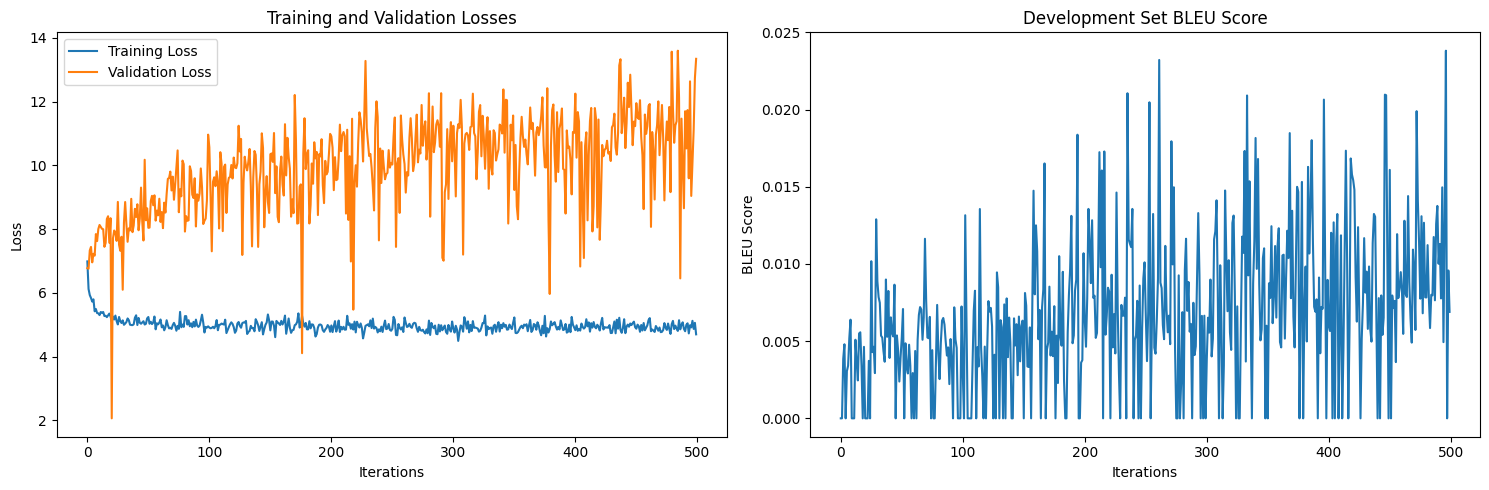

In [28]:
hidden_size = 256
encoder_trial = EncoderLSTM(input_ingredient.n_words, hidden_size,0.1).to(device)
decoder_trial = DecoderLSTM(hidden_size, output_recipe.n_words,0.1).to(device)

plot_losses_1, dev_losses_1, bleu_1 = trainIters(encoder_trial, decoder_trial, 50000, print_every=5000)

In [30]:
losses_1 = pd.DataFrame({"train_loss":plot_losses_1, "dev_loss":dev_losses_1, "Bleu":bleu_1})
losses_1.to_csv("/content/drive/MyDrive/losses_1.csv",index=False)

In [31]:
eval_result_model_11 = evaluate(encoder_trial, decoder_trial, "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits")
' '.join([word for word in eval_result_model_11])

'in a large skillet heat oil in a large skillet saute for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and cook for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and pepper and simmer for about 10 minutes add the garlic and pepper and cook for about 5 minutes add the rice and pepper and cook for about 5 minutes add the garlic and pepper and cook for about 5 minutes add the garlic and pepper and cook for about 10 minutes add the garlic and pepper and cook for about 10 minutes add the remaining ingredients and simmer for about 5 minutes add the garlic and pepper and cook for about 5 minutes add the remaining ingredients and simmer'

In [32]:
eval_result_model_12 = evaluate(encoder_trial, decoder_trial, "2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract")
' '.join([word for word in eval_result_model_12])

'in a large skillet over medium heat until heated skillet heat oil in a large skillet heat oil in a large skillet add the stock and pepper and cook for about 5 minutes add the rice and pepper and cook for about 5 minutes add the rice and pepper and cook for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and pepper and cook for about 5 minutes add the garlic and pepper and cook for about 5 minutes add the rice and the salt and pepper and cook for about 5 minutes add the garlic and pepper and cook for about 5 minutes add the garlic and pepper and cook for about 5 minutes add the remaining ingredients and simmer for about 10 minutes add the remaining ingredients and simmer for about 10 minutes add the remaining ingredients and simmer'

In [33]:
evaluateRandomly(encoder_trial, decoder_trial, test_pairs, n=5)

> 2 lg tomatoes cut in 1 2 in slices 2 tb chopped fresh basil 1 tb chopped fresh parsley 1 tb chopped fresh oregano 1 tb fresh lemon juice 1 ts balsamic vinegar 1 4 ts salt 1 4 ts freshly ground pepper
= arrange tomatoes on a platter slightly overlapping slices . sprinkle with basil parsley and oregano . combine lemon juice and vinegar drizzle over tomatoes . cover and chill 2 hours . sprinkle with salt and pepper .
< in a large skillet heat oil in a large skillet saute for about 5 minutes add the rice and cook for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the rice and pepper and simmer for about 5 minutes add the garlic and pepper and cook for about 5 minutes add the rice and pepper and cook for about 5 minutes add the remaining ingredients and simmer for about 5 minutes add the remaining i

In [34]:
metrics_1 = evaluate_all_metrics(encoder_trial, decoder_trial, test_pairs)

In [35]:
print(f"METEOR score for Baseline 1: {metrics_1[0]}\
      \nBLUE score for Baseline 1: {metrics_1[1]}\
      \nAvg% given items: {metrics_1[2]}\
      \nAvg extra items: {metrics_1[3]}")

METEOR score for Baseline 1: 0.10539060111859745      
BLUE score for Baseline 1: 0.002271339034883259      
Avg% given items: 5.950085196752929      
Avg extra items: 0.981866348972903


------

# Implementation of Baseline 2
In this model, we use decoder with attention

In [36]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))


## Functions for Training and Evaluation

In [37]:
teacher_forcing_ratio = 1


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [38]:
def evaluate_attn(encoder, decoder, sentence, input_ingredient=input_ingredient, output_recipe=output_recipe, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_ingredient, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                try:
                    decoded_words.append(output_recipe.index2word[topi.item()])
                except KeyError as e:
                    #print(f'Warning: {e} not found in output_recipe.index2word, replacing with <UNK>')
                    decoded_words.append('<UNK>')

            decoder_input = topi.squeeze().detach()

        return decoded_words        #, decoder_attentions[:di + 1]

In [39]:
def evaluateRandomly_attn(encoder, decoder, pairs = pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [40]:
def eval_dev_attn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

        return loss.item() / target_length


In [46]:
def trainIters_attn(encoder, decoder, n_iters, dev_pairs = dev_pairs, input_ingredient=input_ingredient,output_recipe=output_recipe, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    dev_loss_total = 0  # Reset every print_every
    dev_losses = []  # track dev losses for plotting
    plot_bleu_scores = []  # track bleu scores for plotting

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        dev_pairs = dev_pairs[:50]
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0

            dev_loss_total = 0
            for dev_pair in dev_pairs:
                input_tensor = tensorFromSentence(input_ingredient, dev_pair[0])
                target_tensor = tensorFromSentence(output_recipe, dev_pair[1])
                dev_loss = eval_dev_attn(input_tensor, target_tensor, encoder, decoder, criterion)
                dev_loss_total += dev_loss
            dev_loss_avg = dev_loss_total / len(dev_pairs)
            dev_loss_total = 0

            dev_bleu_score = calculate_bleu_attn(dev_pairs, encoder, decoder, evaluate_attn)
            
            print('%s (%d %d%%) Train Loss: %.4f | Dev Loss: %.4f | BLEU Score: %.4f' % (timeSince(start, iter / n_iters),
                                                                      iter, iter / n_iters * 100, print_loss_avg, dev_loss_avg, dev_bleu_score))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
            dev_loss = 0
            random.shuffle(dev_pairs)
            dev_pairs_plot = dev_pairs[:round(len(dev_pairs)*0.5)]
            for i in range(len(dev_pairs_plot)):
                input_tensor = tensorFromSentence(input_ingredient, dev_pairs_plot[i][0])
                target_tensor = tensorFromSentence(output_recipe, dev_pairs_plot[i][1])
                dev_loss += eval_dev_attn(input_tensor, target_tensor, encoder, decoder,
                                  criterion)
            dev_loss_avg = dev_loss / len(dev_pairs_plot)
            dev_losses.append(dev_loss_avg)
            # Compute bleu score for plotting
            dev_bleu_score = calculate_bleu_attn(dev_pairs, encoder, decoder, evaluate_attn)
            plot_bleu_scores.append(dev_bleu_score)

    # Plotting the losses and bleu scores
    showPlot(plot_losses, dev_losses, plot_bleu_scores)
    return plot_losses, dev_losses, plot_bleu_scores

In [47]:
def calculate_bleu_attn(pairs, encoder, decoder, evaluate):
    references = []
    hypotheses = []
    
    for pair in pairs:
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = [word for word in output_words if word != "<EOS>"]
        
        references.append(pair[1].split(' '))
        hypotheses.append(output_sentence)
    
    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    
    return bleu_score


## Training and Evaluation

20m 29s (- 184m 26s) (5000 10%) Train Loss: 6.8474 | Dev Loss: 7.0300 | BLEU Score: 0.0000
41m 2s (- 164m 8s) (10000 20%) Train Loss: 6.7930 | Dev Loss: 7.1247 | BLEU Score: 0.0000
61m 11s (- 142m 46s) (15000 30%) Train Loss: 6.7537 | Dev Loss: 7.1088 | BLEU Score: 0.0000
81m 17s (- 121m 56s) (20000 40%) Train Loss: 6.7564 | Dev Loss: 7.2826 | BLEU Score: 0.0000
101m 45s (- 101m 45s) (25000 50%) Train Loss: 6.7502 | Dev Loss: 7.3023 | BLEU Score: 0.0000
122m 44s (- 81m 49s) (30000 60%) Train Loss: 6.7842 | Dev Loss: 7.5322 | BLEU Score: 0.0000
143m 46s (- 61m 37s) (35000 70%) Train Loss: 6.7954 | Dev Loss: 7.4445 | BLEU Score: 0.0000
164m 58s (- 41m 14s) (40000 80%) Train Loss: 6.7764 | Dev Loss: 7.4220 | BLEU Score: 0.0000
185m 48s (- 20m 38s) (45000 90%) Train Loss: 6.7557 | Dev Loss: 7.4933 | BLEU Score: 0.0000
206m 25s (- 0m 0s) (50000 100%) Train Loss: 6.7815 | Dev Loss: 7.3869 | BLEU Score: 0.0000


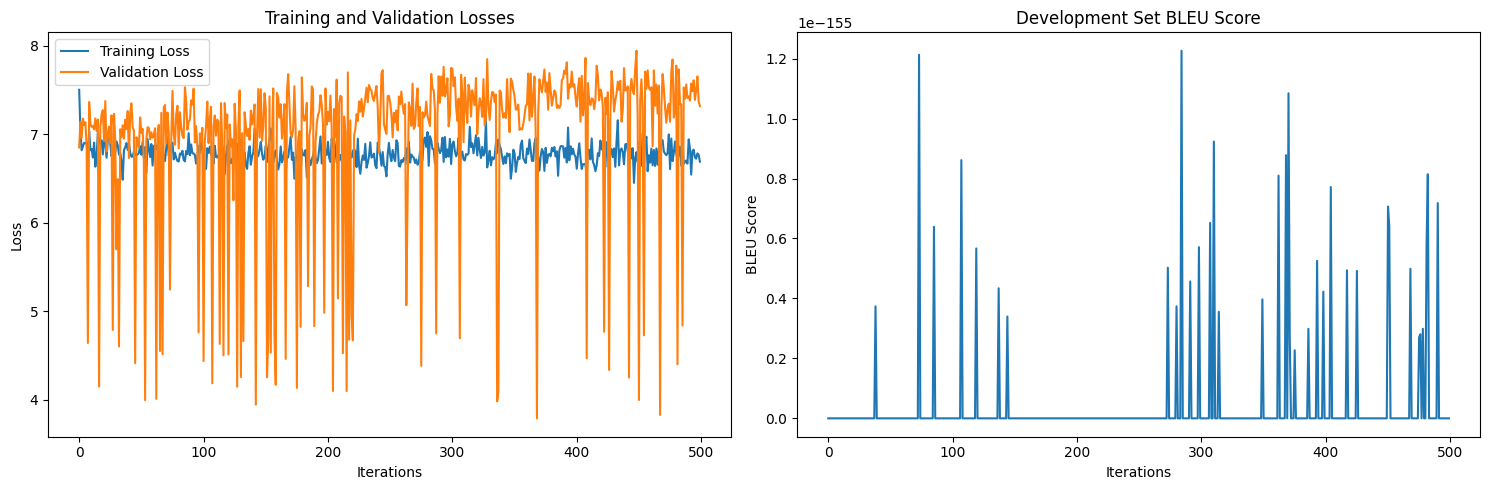

In [48]:
hidden_size = 256
encoder = EncoderLSTM(input_ingredient.n_words, hidden_size,0.1).to(device)
attn_decoder = AttnDecoderLSTM(hidden_size, output_recipe.n_words, dropout_p=0.1).to(device)

plot_losses_2, dev_losses_2, plot_bleu_scores_2 = trainIters_attn(encoder, attn_decoder, 50000, print_every=5000)

In [49]:
losses_2 = pd.DataFrame({"train_loss":plot_losses_2, "dev_loss":dev_losses_2, "Bleu":plot_bleu_scores_2})
losses_2.to_csv("/content/drive/MyDrive/losses_2.csv",index=False)

In [50]:
eval_result_21 = evaluate_attn(encoder, attn_decoder, "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits")
" ".join([word for word in eval_result_21])

'in all oven and large large large large large large large large large large large large large large large large parmesan and parmesan and cheese and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a'

In [51]:
eval_result_22 = evaluate_attn(encoder, attn_decoder, "2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract")
" ".join([word for word in eval_result_22])

'preheat oven according according according according according and x and yolks in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in in'

In [52]:
evaluateRandomly_attn(encoder, attn_decoder, test_pairs, n=5)

> 1 15 oz can navy beans rained and rinsed 1 15 oz can red beans drained and rinsed 1 15 oz can black beans rained and rinsed 2 stalks celery sliced about 1 cup 1 2 c thinly sliced green onion 1 2 c vinegar or more 1 4 c molasses 1 tb dijon style mustard 1 4 ts pepper 2 c torn curly endive
= in a large bowl combine beans celery and green onion . for dressing combine vinegar molasses mustard and pepper and mix well . pour over bean mixture stir to coat . cover and chill for 4 to 24 hours lrb the longer the better ! rrb just before serving stir in endive . enjoy !
< in oven oven oven and bowl in in in in in in in in in in in in in in in in in in in in in in in in in and a a a a a a large large large large large large large large large large large large chicken and chicken and chicken and chicken in in in and chicken and chicken and a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 

In [53]:
metrics_2 = evaluate_all_metrics(encoder,attn_decoder, test_pairs, evaluate_attn)

In [54]:
print(f"METEOR score for Baseline 2: {metrics_2[0]}\
      \nBLUE score for Baseline 2: {metrics_2[1]}\
      \nAvg% given items: {metrics_2[2]}\
      \nAvg extra items: {metrics_2[3]}")

METEOR score for Baseline 2: 0.04356160581054899      
BLUE score for Baseline 2: 5.7519109952469085e-81      
Avg% given items: 1.902473793515234      
Avg extra items: 0.994938141829066


---------------

# Implementation of Extension 1
In this some preprocessing have been done and then multiple layered LSTM is used in both encoder-decoder.


In [56]:
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')


lemmatizer = WordNetLemmatizer()
stop_words = set(nltk_stopwords.words('english'))

def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z ]', '', sentence)  # Keep only letters
    tokens = re.split(r'\s+', sentence.strip())  # Split based on one or more whitespace characters
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens]   # Lemmatize and remove numbers
    return ' '.join(tokens)


def prepareData(datapath, percentage=100):
    pairs = readData(datapath)
    print("Read %s ingredient-recipe pairs" % len(pairs))

    # Preprocess each sentence in the pairs
    pairs = [(preprocess_sentence(pair[0]), preprocess_sentence(pair[1])) for pair in pairs]

    pairs = filterPairs(pairs)
    print("Trimmed to %s ingredient-recipe pairs" % len(pairs))

    if percentage < 100:
        num_pairs = int(len(pairs) * percentage / 100)
        pairs = random.sample(pairs, num_pairs)
        print("Using %s%% of pairs: %s ingredient-recipe pairs" % (percentage, len(pairs)))

    print("Counting words...")
    input_ingredient = Lang()
    output_recipe = Lang()
    for pair in pairs:
        input_ingredient.addSentence(pair[0])
        output_recipe.addSentence(pair[1])
    print("Counted words:")
    print("Ingredients:", input_ingredient.n_words)
    print("Recipes:", output_recipe.n_words)
    return input_ingredient, output_recipe, pairs


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
input_ingredient, output_recipe, pairs = prepareData('train',50)
pairs[1]

Read 143907 ingredient-recipe pairs
Trimmed to 139497 ingredient-recipe pairs
Using 50% of pairs: 69748 ingredient-recipe pairs
Counting words...
Counted words:
Ingredients: 13029
Recipes: 25241


('tb butter c flour c sugar egg c milk t baking powder t vanilla t cinnamon c fresh blueberry sprinkled little sugar',
 'preheat oven grease springform pan mixing bowl cut tablespoon butter flour sugar thoroughly mixed take cup mixture set aside mixture remaining bowl add egg milk baking powder vanilla pour batter prepared pan spread batter around side pan completely lining pan forming hollow center pan place blueberry hollow add tablespoon butter cinnamon reserved cup flour mixture work mixture finger crumbly sprinkle crumb top berry bake minute reduce heat bake minute serve warm cold')

In [58]:
dev_input_ingredient, dev_output_recipe, dev_pairs = prepareData('dev',10)

Read 1000 ingredient-recipe pairs
Trimmed to 973 ingredient-recipe pairs
Using 10% of pairs: 97 ingredient-recipe pairs
Counting words...
Counted words:
Ingredients: 615
Recipes: 1108


In [59]:
test_input_ingredient, test_output_recipe, test_pairs = prepareData('test')

Read 1000 ingredient-recipe pairs
Trimmed to 970 ingredient-recipe pairs
Counting words...
Counted words:
Ingredients: 1895
Recipes: 3306


In [ ]:
class stackedEncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super(stackedEncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),  # Initial hidden state 'h'
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))  # Initial cell state 'c'


class stackedDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout=0.1):
        super(stackedDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output = self.dropout(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHiddenCell(self):
        return (
            torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
            torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
        )


## Training and Evaluation

13m 12s (- 118m 48s) (5000 10%) Train Loss: 7.1238 | Dev Loss: 4.0143 | Dev BLEU: 0.0000
26m 32s (- 106m 8s) (10000 20%) Train Loss: 6.9600 | Dev Loss: 6.6942 | Dev BLEU: 0.0000
39m 53s (- 93m 5s) (15000 30%) Train Loss: 7.1015 | Dev Loss: 4.1832 | Dev BLEU: 0.0000
53m 16s (- 79m 54s) (20000 40%) Train Loss: 7.1484 | Dev Loss: 3.9245 | Dev BLEU: 0.0000
66m 20s (- 66m 20s) (25000 50%) Train Loss: 7.0517 | Dev Loss: 5.4213 | Dev BLEU: 0.0000
79m 46s (- 53m 10s) (30000 60%) Train Loss: 7.0174 | Dev Loss: 5.4432 | Dev BLEU: 0.0000
93m 0s (- 39m 51s) (35000 70%) Train Loss: 7.0229 | Dev Loss: 6.8222 | Dev BLEU: 0.0000
106m 20s (- 26m 35s) (40000 80%) Train Loss: 7.0311 | Dev Loss: 6.8714 | Dev BLEU: 0.0000
119m 42s (- 13m 18s) (45000 90%) Train Loss: 6.9424 | Dev Loss: 6.9587 | Dev BLEU: 0.0000
132m 58s (- 0m 0s) (50000 100%) Train Loss: 6.8959 | Dev Loss: 4.0530 | Dev BLEU: 0.0000


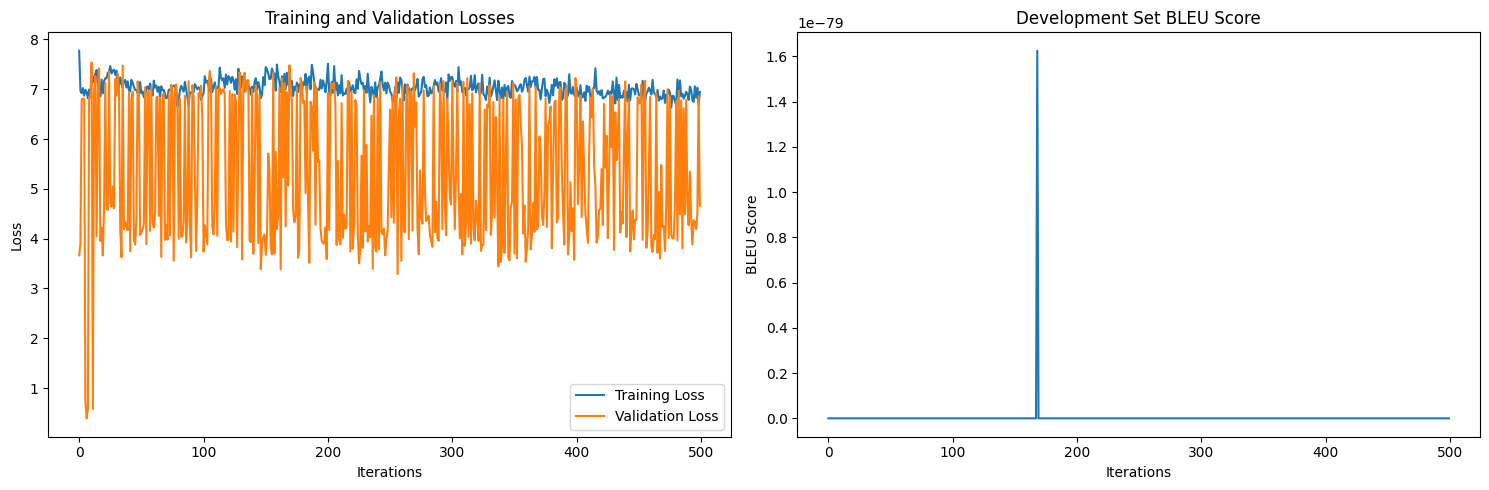

In [ ]:
hidden_size = 256
encoder_stacked = stackedEncoderLSTM(input_ingredient.n_words, hidden_size, num_layers=3).to(device)
decoder_stacked = stackedDecoderLSTM(hidden_size, output_recipe.n_words, num_layers=3).to(device)

plot_losses_3, dev_losses_3, bleu_losses_3 = trainIters(encoder_stacked, decoder_stacked, 50000, print_every=5000)

In [ ]:
losses_3 = pd.DataFrame({"train_loss":plot_losses_3, "dev_loss":dev_losses_3, "Bleu":bleu_losses_3})
losses_3.to_csv("/content/drive/MyDrive/losses_3.csv",index=False)

In [ ]:
eval_result_31 = evaluate(encoder_stacked, decoder_stacked, "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits")
" ".join(word for word in eval_result_31)

'place oven oven flour add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add add <EOS>'

In [ ]:
eval_result_32 = evaluate(encoder_stacked, decoder_stacked, "2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract")
" ".join(word for word in eval_result_32)

'place oven oven flour add add add add add add add add add add add add add add add add add add add add <EOS>'

In [ ]:
evaluateRandomly(encoder_stacked, decoder_stacked, test_pairs, n=5)

> pk dry yeast t sugar c warm water c butter room temperature c sugar t salt tb grated lemon peel c nonfat dry milk cup unbleached flour c ground poppy seed c sugar c raisin c milk glaze egg beaten tsp wat
= small cup dissolve yeast sugar water let stand minute meanwhile combine butter sugar salt tbsp lemon peel milk large mixing bowl add cup flour alternately yeast mixture blend dough well turn dough onto floured board add flour necessary put dough greased bowl turning top greased let rise warm draft free place doubled bulk hour dough rising prepare filling combine poppy seed sugar raisin milk rest lemon peel top half double boiler cook hot water mixture spreading consistency stir constantly remove heat cool room temperature punch dough divide half roll piece long rectangle inch thick spread filling top piece roll pinch seam together filling ca n come place roll large greased baking sheet brush glaze cover roll wax paper laid across water glass paper n touch dough let rise minute appl

In [ ]:
metrics_3 = evaluate_all_metrics(encoder_stacked, decoder_stacked, test_pairs)

In [ ]:
print(f"METEOR score for Extended Model 1: {metrics_3[0]}\
      \nBLUE score for Extended Model 1: {metrics_3[1]}\
      \nAvg% given items: {metrics_3[2]}\
      \nAvg extra items: {metrics_3[3]}")

METEOR score for Extended Model 1: 0.023611810248502018      
BLUE score for Extended Model 1: 2.491412735892993e-157      
Avg% given items: 0.5483271235085684      
Avg extra items: 0.994684915735158


-----------------------------

# Implementation of Extension 2
In this, we have used same preprocessing as Extension 1 but added a coverage mechanism in the decoder in order to deal with problem of repetition.

In [32]:
class DecoderCoverage(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate, coverage_weight=0.2):
        super(DecoderCoverage, self).__init__()
        self.hidden_size = hidden_size
        self.coverage_weight = coverage_weight

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.Wc = nn.Linear(1, hidden_size, bias=False)  # Coverage vector weights
        self.Wh = nn.Linear(hidden_size, hidden_size, bias=False)  # Hidden state weights
        self.Ws = nn.Linear(hidden_size, hidden_size, bias=False)  # Decoder state weights
        self.v = nn.Linear(hidden_size, 1, bias=False)  # Context vector weights

    def forward(self, input, hidden, coverage):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        lstm_out, hidden = self.lstm(embedded,hidden)

        e = self.v(torch.tanh(self.Wh(hidden[0]) + self.Ws(lstm_out) + self.Wc(coverage)))
        attn_weights = F.softmax(e, dim=1)
        coverage = coverage + attn_weights             # Update coverage vector

        output = self.softmax(self.out(lstm_out[0]))
        return output, hidden, coverage, attn_weights

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))


## Functions for Training and Evaluation

In [33]:
def train_coverage(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, coverage_weight=0.5):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
    coverage = torch.zeros(1, 1, 1, device=device)

    loss = 0
    coverage_loss=0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, coverage, attn_weights = decoder(
                decoder_input, decoder_hidden, coverage)
            #coverage = coverage.clone() + attn_weights
            coverage_loss = torch.sum(torch.min(attn_weights, coverage))
            #target_tensor[di] = target_tensor[di].view(-1) 
            ce_loss = F.nll_loss(decoder_output, target_tensor[di])
            loss += (ce_loss + coverage_weight*coverage_loss)
            #loss += decoder.total_loss(decoder_output, target_tensor[di], attn_weights, coverage)
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, coverage, attn_weights = decoder(
                decoder_input, decoder_hidden, decoder_cell, coverage)
            #coverage = coverage.clone() + attn_weights 
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            coverage_loss = torch.sum(torch.min(attn_weights, coverage))
            #target_tensor[di] = target_tensor[di].view(-1) 
            ce_loss = F.nll_loss(decoder_output, target_tensor[di])
            loss += (ce_loss + coverage_weight*coverage_loss)
            #loss += decoder.total_loss(decoder_output, target_tensor[di], attn_weights, coverage)
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [34]:
def trainIters_coverage(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, dev_pairs=dev_pairs):
    start = time.time()
    plot_losses = []
    dev_losses = []
    dev_bleu_scores = []
    plot_bleu_scores = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    random.shuffle(dev_pairs)
    dev_pairs = dev_pairs[:50]
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_coverage(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            # Evaluate on the validation set and print results
            dev_loss = 0
            for i in range(len(dev_pairs)):
                input_tensor = tensorFromSentence(input_ingredient, dev_pairs[i][0])
                target_tensor = tensorFromSentence(output_recipe, dev_pairs[i][1])
                dev_loss += eval_dev(encoder, decoder,input_tensor, target_tensor, 
                                  criterion)
            dev_loss_avg = dev_loss / len(dev_pairs)
            dev_bleu_score = calculate_bleu_coverage(dev_pairs, encoder, decoder, input_ingredient, output_recipe)
            dev_bleu_scores.append(dev_bleu_score)
            print('%s (%d %d%%) Train Loss: %.4f | Dev Loss: %.4f | Dev BLEU: %.4f' % (timeSince(start, iter / n_iters),
                                                                            iter, iter / n_iters * 100,
                                                                            print_loss_avg, dev_loss_avg,
                                                                            dev_bleu_score))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            # Calculate the BLEU score and dev loss every plot_every iterations
            dev_loss = 0
            random.shuffle(dev_pairs)
            dev_pairs_plot = dev_pairs[:round(len(dev_pairs)*0.5)]
            for i in range(len(dev_pairs_plot)):
                input_tensor = tensorFromSentence(input_ingredient, dev_pairs_plot[i][0])
                target_tensor = tensorFromSentence(output_recipe, dev_pairs_plot[i][1])
                dev_loss += eval_dev(encoder, decoder,input_tensor, target_tensor, 
                                  criterion)
            dev_loss_avg = dev_loss / len(dev_pairs_plot)
            dev_bleu_score = calculate_bleu_coverage(dev_pairs_plot, encoder, decoder, input_ingredient, output_recipe)
            plot_bleu_scores.append(dev_bleu_score)
            dev_losses.append(dev_loss_avg)

    showPlot(plot_losses, dev_losses, plot_bleu_scores)
    return plot_losses, dev_losses, plot_bleu_scores


In [35]:
def eval_dev(encoder, decoder, input_tensor, target_tensor, criterion, max_length=MAX_LENGTH, coverage_weight=0.5):
    with torch.no_grad():
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        coverage = torch.zeros(1, 1, 1, device=device)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        for di in range(target_length):
            decoder_output, decoder_hidden, coverage, attn_weights = decoder(decoder_input, decoder_hidden, coverage)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            coverage_loss = torch.sum(torch.min(attn_weights, coverage))
            #target_tensor[di] = target_tensor[di].view(-1) 
            ce_loss = F.nll_loss(decoder_output, target_tensor[di])
            loss += (ce_loss + coverage_weight*coverage_loss)
            if decoder_input.item() == EOS_token:
                break

        return loss.item() / target_length

In [36]:
def evaluate_coverage(encoder, decoder, sentence, input_ing = input_ingredient, output_rec = output_recipe, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_ing, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        coverage = torch.zeros(1, 1, 1, device=device)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, coverage, attn_weights = decoder(
                decoder_input, decoder_hidden, coverage)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_recipe.index2word[topi.item()])


            decoder_input = topi.squeeze().detach()

        return decoded_words

In [37]:
def calculate_bleu_coverage(pairs, encoder, decoder, input_ing = input_ingredient, output_rec = output_recipe):
    references, hypotheses = [], []
    
    # Loop through each pair of input and target
    for pair in pairs:
        input, target = pair[0], pair[1]
        # Evaluate the input sentence
        output_words = evaluate_coverage(encoder, decoder, input, input_ing, output_rec)
        # Remove the EOS token at the end, if present
        if output_words[-1] == '<EOS>':
            output_words = output_words[:-1]
            
        references.append([target.split(' ')])
        hypotheses.append(output_words)
        
    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    
    return bleu_score

In [38]:
def evaluateRandomly_coverage(encoder, decoder, pairs, input_ing = input_ingredient, output_rec = output_recipe, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate_coverage(encoder, decoder, pair[0], input_ing, output_rec)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluation

16m 13s (- 145m 57s) (5000 10%) Train Loss: 5.5510 | Dev Loss: 7.2944 | Dev BLEU: 0.0115
32m 41s (- 130m 44s) (10000 20%) Train Loss: 5.2308 | Dev Loss: 9.0623 | Dev BLEU: 0.0102
49m 22s (- 115m 13s) (15000 30%) Train Loss: 5.1838 | Dev Loss: 8.1429 | Dev BLEU: 0.0086
66m 7s (- 99m 11s) (20000 40%) Train Loss: 5.1655 | Dev Loss: 8.8260 | Dev BLEU: 0.0032
82m 48s (- 82m 48s) (25000 50%) Train Loss: 5.1676 | Dev Loss: 9.3122 | Dev BLEU: 0.0026
99m 36s (- 66m 24s) (30000 60%) Train Loss: 5.1602 | Dev Loss: 9.3517 | Dev BLEU: 0.0066
116m 35s (- 49m 58s) (35000 70%) Train Loss: 5.1823 | Dev Loss: 9.1004 | Dev BLEU: 0.0026
133m 20s (- 33m 20s) (40000 80%) Train Loss: 5.2110 | Dev Loss: 10.0458 | Dev BLEU: 0.0059
150m 9s (- 16m 41s) (45000 90%) Train Loss: 5.2052 | Dev Loss: 8.6865 | Dev BLEU: 0.0081
166m 32s (- 0m 0s) (50000 100%) Train Loss: 5.2501 | Dev Loss: 9.5390 | Dev BLEU: 0.0076


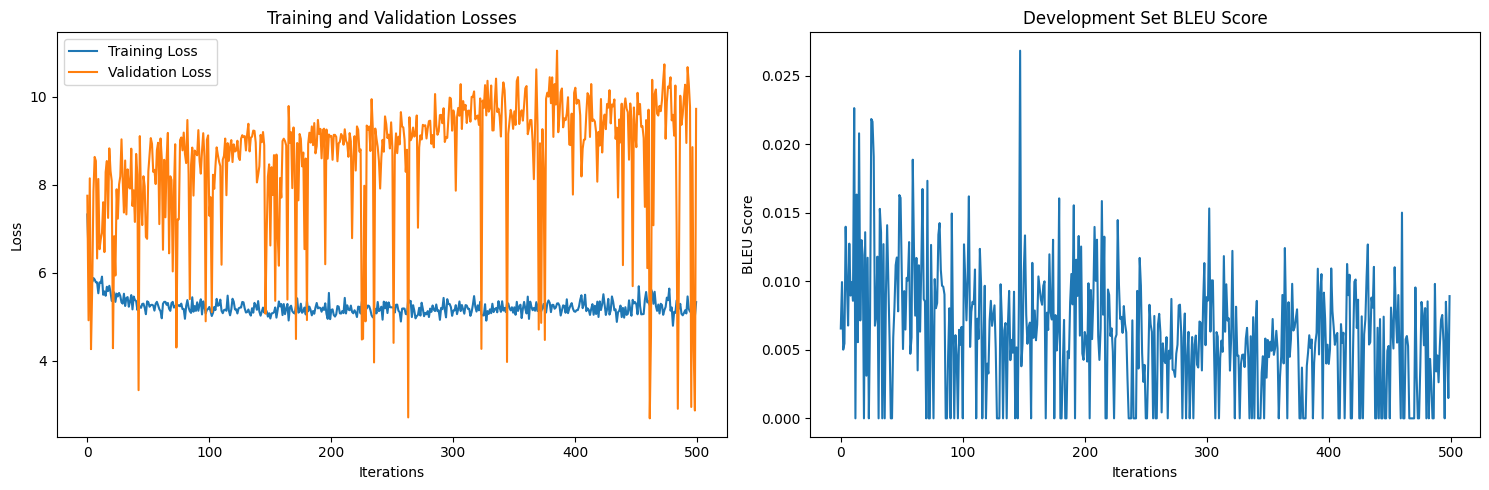

In [39]:
hidden_size = 256
encoder4 = EncoderLSTM(input_ingredient.n_words, hidden_size,0.1).to(device)
decoder4 = DecoderCoverage(hidden_size, output_recipe.n_words, 0.1).to(device)
plot_losses_4, dev_losses_4, dev_blue_4 = trainIters_coverage(encoder4, decoder4, 50000, print_every=5000)

In [41]:
import pandas as pd
losses_4 = pd.DataFrame({"train_loss":plot_losses_4, "dev_loss":dev_losses_4, "Bleu":dev_blue_4})
losses_4.to_csv("/content/drive/MyDrive/losses_4.csv",index=False)

In [42]:
eval_result_model_41 = evaluate_coverage(encoder4, decoder4, "10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits")
" ".join([word for word in eval_result_model_41])

'in a large bowl combine all ingredients except the flour and salt and pepper to taste to the pan add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is'

In [43]:
eval_result_model_42 = evaluate_coverage(encoder4, decoder4, "2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract")
" ".join([word for word in eval_result_model_42])

'in a large bowl combine all ingredients except the flour and salt and pepper to taste to the pan add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is'

In [44]:
evaluateRandomly_coverage(encoder4, decoder4, test_pairs,n=5)

> 1 c uncooked macaroni 1 4 ts pepper 3 4 c mayonnaise or salad 1 l 2 cups cut up cooked dressing chicken 1 tb finely chopped onion 1 c chopped cucumber 1 2 ts salt
= many macaroni shapes are now available . choose from spiral bow tie elbow . ring or shell macaroni . cook macaroni as directed on package drain . rinse with cold water drain . mix mayonnaise onion salt and pepper . toss with macaroni chicken and cucumber cover and refrigerate about 2 hours or until chilled . 4 servings .
< in a large bowl combine all ingredients except the flour and salt and pepper to taste to the pan add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the remaining ingredients and cook until the mixture is tender add the r

In [45]:
metrics_4 = evaluate_all_metrics(encoder4, decoder4, test_pairs, evaluate_coverage)

In [46]:
print(f"METEOR score for Extended Model 2: {metrics_4[0]}\
      \nBLUE score for Extended Model 2: {metrics_4[1]}\
      \nAvg% given items: {metrics_4[2]}\
      \nAvg extra items: {metrics_4[3]}")

METEOR score for Extended Model 2: 0.10246013725328802      
BLUE score for Extended Model 2: 0.0026255883018070545      
Avg% given items: 4.707476747803993      
Avg extra items: 0.9860099083552734


---------------
# Plots for Analysis

In [51]:
model1_errors = pd.read_csv('/content/drive/MyDrive/losses_1.csv')
model2_errors = pd.read_csv('/content/drive/MyDrive/losses_2.csv')
model3_errors = pd.read_csv('/content/drive/MyDrive/losses_3.csv')
model4_errors = pd.read_csv('/content/drive/MyDrive/losses_4.csv')

In [53]:
train_error1 = model1_errors['train_loss'].tolist()
train_error2 = model2_errors['train_loss'].tolist()
train_error3 = model3_errors['train_loss'].tolist()
train_error4 = model4_errors['train_loss'].tolist()
dev_error1 = model1_errors['dev_loss'].tolist()
dev_error2 = model2_errors['dev_loss'].tolist()
dev_error3 = model3_errors['dev_loss'].tolist()
dev_error4 = model4_errors['dev_loss'].tolist()


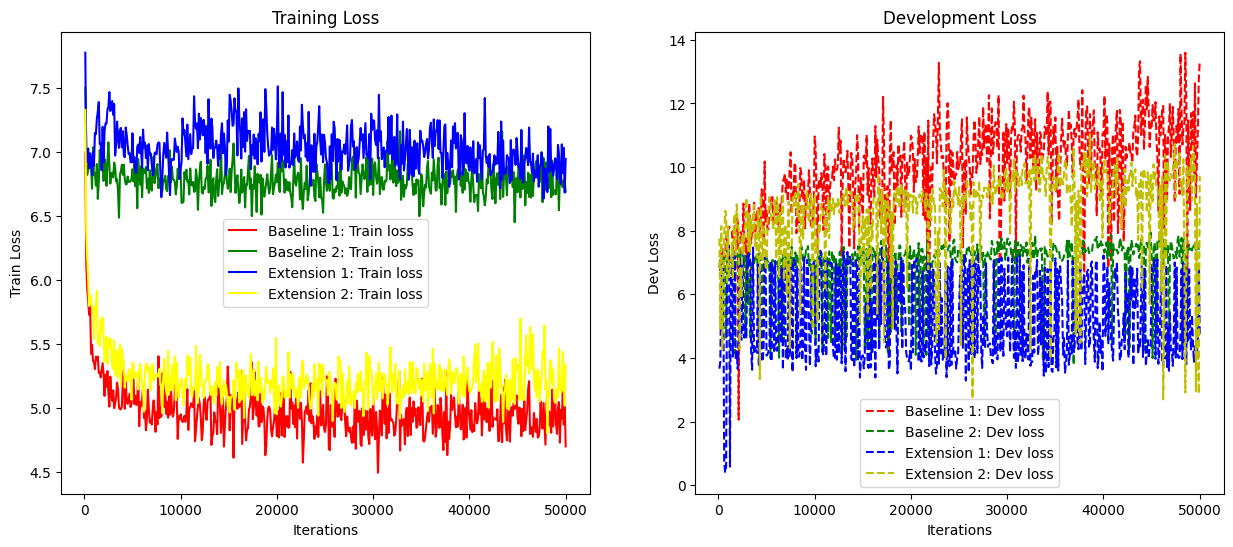

In [58]:
from matplotlib import markers
x = list(range(100, 50001,100))
fig, ax = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

# Plot the data

ax[0].plot(x, train_error1, color="red", label='Baseline 1: Train loss')
ax[1].plot(x, dev_error1, 'r--', label='Baseline 1: Dev loss')

ax[0].plot(x, train_error2, color="green", label='Baseline 2: Train loss')
ax[1].plot(x, dev_error2, 'g--', label='Baseline 2: Dev loss')

ax[0].plot(x, train_error3, color="blue", label='Extension 1: Train loss')
ax[1].plot(x, dev_error3, 'b--', label='Extension 1: Dev loss')

ax[0].plot(x, train_error4, color="yellow", label='Extension 2: Train loss')
ax[1].plot(x, dev_error4, 'y--', label='Extension 2: Dev loss')

# Add title, labels and legend
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Train Loss')
ax[0].legend()

ax[1].set_title('Development Loss')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Dev Loss')
ax[1].legend()

# Show the plot
plt.show()

# End
-------------------